# Online Drift Detection on the Wine Quality Dataset

オンラインドリフト検出の練習。

以下のサンプルを実行する。

https://github.com/SeldonIO/alibi-detect/blob/master/docs-gb/examples/cd_online_wine.ipynb



## 概要

---

### ワイン品質データセットに対するオンライン・ドリフト検知

運用中のモデルでは、データ（モデルへの問い合わせ）は通常、時間順に逐次到着します。そのため、ドリフトが発生したら、できるだけ早く検知したいと考えます。1つの方法は、*W* タイムステップごとにドリフト検定を行い、直前の検定から到着した *W* 個のサンプルを使うことです。この戦略は **alibi-detect** に実装されている任意のオフライン検知器でも実現できますが、「小さな（わずかな）ドリフトに敏感であること」と「大きな（深刻な）ドリフトに素早く反応すること」の両方を同時に満たすのは難しいです。窓幅 *W* が小さすぎると、わずかなドリフトは検出できません。逆に大きすぎると、検定を行う点の間隔が広がり、深刻なドリフトへの反応が遅れてしまいます。

別の戦略として、データが到着するたびに毎回検定を行う方法があります。しかし通常のオフライン手法は適用できません。なぜなら、p値（有意確率）を計算する処理が高コストすぎること、さらにテストデータに重なり合う窓（オーバーラップする窓）を使うと、検定結果が互いに相関してしまうのに、それを考慮できないためです。

これに対してオンライン検知器は、最初の *W* 個のデータ点を使って一度だけ検定統計量（test-statistic）を計算し、その後は低コストで逐次的に更新していくことで動作します。ドリフトが起きていないとき、検定統計量は期待値の周りで揺らぎます。ドリフトが起きると、検定統計量は上向きにずれ始めます。そして、あらかじめ設定されたしきい値を超えると、ドリフトが検知されます。

オフライン検知器では、しきい値として p値（偽陽性率）を指定する必要があります。一方、**alibi-detect** のオンライン検知器では、期待実行時間（ERT: expected run-time）を指定する必要があります（これは偽陽性率を反転させた量です）。ERTとは、ドリフトが無い状況において、誤検知を起こすまでに検知器が平均して何タイムステップ動作すべきか、という要求を表します。通常はERTを大きくしたいのですが、その場合、検知器は鈍感になり、実際にドリフトが起きたときの反応が遅くなります。つまり、期待実行時間と期待検知遅れの間にはトレードオフがあります。

望むERTを実現するために、しきい値は初期設定フェーズでシミュレーションにより調整されます。この設定プロセスは、参照データ（多くの場合、対象モデルの学習データ）が十分に多いときにのみ適しています（理想的には、望むERTよりもおよそ1桁多い量）。設定にはコストがかかり得ます（GPUがあれば多少軽くなります）が、一度設定すれば、運用時には低コストで動作させることができます。

このノートブックでは、検定統計量として2標本間距離の指標を2種類用い、オンライン・ドリフト検知を実演します。用いる指標は、最大平均差（MMD: maximum mean discrepancy）と、最小二乗密度差（LSDD: least-squared density difference）で、どちらも低コストで逐次更新が可能です。

---

### バックエンド（Backend）

オンライン検知器は、**PyTorch** と **TensorFlow** の両方の枠組みで実装されており、CPU と GPU の両方をサポートしています。さまざまな前処理の手順も、両方の枠組みに対して Alibi Detect に最初から用意されており、このノートブック内で例を示します。ただし、Alibi Detect は PyTorch を自動ではインストールしません。インストール方法については **PyTorch docs** を確認してください。

---

### データセット（Dataset）

**Wine Quality Data Set** は、白ワインが 4898 サンプル、赤ワインが 1599 サンプルから成ります。各サンプルには、（専門家によって判定された）品質の値が付いており、さらに酸度、密度、pH などを示す 11 個の数値特徴量があります。ここでは、これらの特徴量から白ワインの品質を予測する回帰問題を考えます。その後、このモデルが赤ワインの品質予測にも適したままかどうか、あるいは基礎となる分布の変化をドリフトとして扱うべきかどうかを検討します。

---

### MMD と PyTorch によるオンライン検知（Online detection with MMD and Pytorch）

最大平均差（MMD: Maximum Mean Discrepency）は、再生核ヒルベルト空間 $\mathcal{F}$ における平均埋め込み $\mu_p$ と $\mu_q$ に基づいて、2つの分布 $p$ と $q$ の間の距離を測る指標です。

$$
\mathrm{MMD}(\mathcal{F}, p, q) = \|\mu_p - \mu_q\|_{\mathcal{F}}^2
$$

参照サンプル $\{X_i\}_{i=1}^N$ と、テストサンプル $\{Y_i\}_{i=t}^{t+W}$ が与えられたとき、背後にある2つの分布間の「二乗MMD」について、不偏推定量
$\widehat{\mathrm{MMD}}^2(\mathcal{F}, \{X_i\}_{i=1}^N, \{Y_i\}_{i=t}^{t+W})$
を計算できます。

参照窓とテスト窓の大きさがそれぞれ $N$ と $W$ のとき、この計算は状況によっては高コストになり得ます。しかし、一度計算してしまえば、統計量を低コストで更新して、$\{X_i\}_{i=1}^N$ と $\{Y_i\}_{i=t+1}^{t+1+W}$ の背後にある分布同士の二乗MMDを推定できるため、オンラインのドリフト検知に適しています。

既定では、放射基底関数カーネル（RBFカーネル）を使用しますが、利用者は好みのカーネルを検知器に渡すこともできます。



## サンプルコードの実行

In [11]:
import matplotlib.pyplot as plt
import numpy as np
# import torch
import tensorflow as tf
import pandas as pd
import scipy
from sklearn.decomposition import PCA

np.random.seed(0)
#torch.manual_seed(0)
tf.random.set_seed(0)

### データを読み込む

In [12]:
import pandas as pd

# =========================
# 0) 保存先フォルダ（必要なら変更）
# =========================

RED_PATH   = r".\\data\\test_1_sample_wine\\winequality-red.csv"
WHITE_PATH = r".\\data\\test_1_sample_wine\\winequality-white.csv"

# =========================
# 1) 初回だけ実行（ダウンロード→ローカル保存）
#    2回目以降はここをコメントアウトしたままにする
# =========================
# red = pd.read_csv(
#     "https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-red.csv", sep=";"
# )
# white = pd.read_csv(
#     "https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-white.csv", sep=";"
# )

# # ローカル保存（2回目以降はこのファイルを読む）
# red.to_csv(RED_PATH, index=False)
# white.to_csv(WHITE_PATH, index=False)

# =========================
# 2) 2回目以降（ローカルから読み込み）
# =========================
red = pd.read_csv(RED_PATH)
white = pd.read_csv(WHITE_PATH)

white.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [13]:
# データの緒言を確認
red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### ドリフト検知の比較ができる形」に白ワイン（基準）と赤ワイン（変化後）データを前処理して、特徴量行列 `X`（白）と `X_corr`（赤）を作る

1) NumPy配列（float32）に変換  
   - 演算を統一・高速化するため。

2) 白ワインの列ごとの最大値で正規化（0〜1スケール）  
   - `col_maxes = white.max(axis=0)` を分母にして  
     `white/col_maxes`, `red/col_maxes` を行う。  
   - 白ワインを「参照分布（基準）」として尺度を固定し、赤ワインのズレ（ドリフト）を見やすくする。

3) 行をシャッフル  
   - 並び順の偏りをなくし、後続処理で順番に引きずられないようにする。

4) 最後の列（quality）を除いて特徴量だけ取り出す  
   - `X = white[:, :-1]`  … 白ワイン特徴量（参照側）  
   - `X_corr = red[:, :-1]` … 赤ワイン特徴量（ドリフト側）

結果：
- `X` と `X_corr` は「特徴量の分布が変わったか」を MMD などで比較するための入力になる。


In [14]:

# =========================
# 0) 事前確認（pandas DataFrame から来ている想定）
#    white, red は「最後の列が quality」の表
# =========================
print("=== before convert ===")
print("type(white) =", type(white))
print("type(red)   =", type(red))
print("white.shape =", getattr(white, "shape", None))
print("red.shape   =", getattr(red, "shape", None))

# =========================
# 1) NumPy配列（float32）に変換
#    - 演算を速く・統一的に行うため
# =========================
white = np.asarray(white, np.float32)
red   = np.asarray(red,   np.float32)

print("\n=== after convert to np.float32 ===")
print("white.dtype =", white.dtype, " white.shape =", white.shape)
print("red.dtype   =", red.dtype,   " red.shape   =", red.shape)

# =========================
# 2) サンプル数（行数）を取得
# =========================
n_white, n_red = white.shape[0], red.shape[0]
print("\n=== number of samples ===")
print("n_white =", n_white)
print("n_red   =", n_red)

# =========================
# 3) 列ごとの最大値（白ワイン側）を計算
#    - 各特徴量を 0〜1 に近い範囲へスケールするための分母
#    - 最後の列 quality も含まれる点に注意（列全部対象）
# =========================
col_maxes = white.max(axis=0)

print("\n=== col_maxes computed from WHITE (per column max) ===")
print("col_maxes.shape =", col_maxes.shape)
print("col_maxes (first 5) =", col_maxes[:5])
print("col_maxes (last)    =", col_maxes[-1], "  <- max of quality column (white)")

# =========================
# 4) 正規化（スケール合わせ）
#    - white の各列を col_maxes で割る
#    - red も同じ col_maxes で割る（白ワイン基準で尺度を揃える意図）
# =========================
white = white / col_maxes
red   = red   / col_maxes

print("\n=== after normalization by col_maxes ===")
print("white: min/max (overall) =", float(white.min()), float(white.max()))
print("red  : min/max (overall) =", float(red.min()),   float(red.max()))
print("quality column range (white) =", float(white[:, -1].min()), float(white[:, -1].max()))
print("quality column range (red)   =", float(red[:, -1].min()),   float(red[:, -1].max()))

# =========================
# 5) 行のシャッフル（順番をランダムに並び替え）
#    - 学習/評価の偏りを減らす
# =========================
perm_white = np.random.permutation(n_white)
perm_red   = np.random.permutation(n_red)

print("\n=== permutation indices (first 10) ===")
print("perm_white[:10] =", perm_white[:10])
print("perm_red[:10]   =", perm_red[:10])

white = white[perm_white]
red   = red[perm_red]

print("\n=== after shuffle ===")
print("white[0] (first row, first 5 cols) =", white[0, :5])
print("red[0]   (first row, first 5 cols) =", red[0, :5])

# =========================
# 6) 入力特徴量だけを取り出す（最後の列 quality を除外）
#    - X: 白ワイン特徴量（参照データ側）
#    - X_corr: 赤ワイン特徴量（ドリフト側として扱う）
# =========================
X      = white[:, :-1]
X_corr = red[:,   :-1]

print("\n=== feature matrices ===")
print("X.shape      =", X.shape,      "  (white features, exclude quality)")
print("X_corr.shape =", X_corr.shape, "  (red features, exclude quality)")



=== before convert ===
type(white) = <class 'pandas.core.frame.DataFrame'>
type(red)   = <class 'pandas.core.frame.DataFrame'>
white.shape = (4898, 12)
red.shape   = (1599, 12)

=== after convert to np.float32 ===
white.dtype = float32  white.shape = (4898, 12)
red.dtype   = float32  red.shape   = (1599, 12)

=== number of samples ===
n_white = 4898
n_red   = 1599

=== col_maxes computed from WHITE (per column max) ===
col_maxes.shape = (12,)
col_maxes (first 5) = [14.2    1.1    1.66  65.8    0.346]
col_maxes (last)    = 9.0   <- max of quality column (white)

=== after normalization by col_maxes ===
white: min/max (overall) = 0.0 1.0
red  : min/max (overall) = 0.0 1.8518518209457397
quality column range (white) = 0.3333333432674408 1.0
quality column range (red)   = 0.3333333432674408 0.8888888955116272

=== permutation indices (first 10) ===
perm_white[:10] = [2762   42 1419 3664 2125 2154 1457 3957 1248 1013]
perm_red[:10]   = [1009 1356  983 1160  335  894  454 1516  897  419]

==

### PCA 前処理のデモ

目的：
- 特徴量 11 次元のデータを、PCA で 2 次元に落として可視化し、
  「白ワイン（参照）」と「赤ワイン（ドリフト側）」が低次元空間で分かれて見えるかを確認する。
- ただし、検知器に偏り（リーク）を入れないために、PCA の学習（fit）は参照データの一部だけで行い、
  その学習に使ったデータは「参照データ」としては使わない。

---

#### 1) 白ワイン（参照データ）を 3 分割する

前提：
- `X` は白ワインの特徴量行列（shape: [n_white, 11]）
- `n_white = X.shape[0]`

分割：
- `X_train` : PCA を学習するためのデータ（白ワインの前半 1/2）
- `X_ref`   : ドリフト検知器の参照データとして使う（白ワインの 1/4）
- `X_h0`    : 運用中に「ドリフトなし（H0）」として流れてくる想定の白ワイン（残り 1/4）

コード：
- `X_train = X[:(n_white//2)]`
- `X_ref   = X[(n_white//2):(3*n_white//4)]`
- `X_h0    = X[(3*n_white//4):]`

意図：
- PCA の学習に使ったデータが、そのまま参照データに混ざると「前処理が参照データに最適化されすぎる」
  可能性があるため、学習用と参照用を分ける。

---

#### 2) PCA（2次元）を学習する

目的：
- 11 次元 → 2 次元への射影（変換）を作る。

コード：
- `pca = PCA(2)`
- `pca.fit(X_train)`

ここでの注意：
- `fit` は「主成分（低次元空間の軸）」を学習する操作。
- 学習は `X_train`（白ワインの一部）だけで行う。

---

#### 3) PCA で 2 次元へ変換し、散布図で比較する

変換：
- `enc_h0 = pca.transform(X_h0)`     （白ワイン：ドリフトなし側）
- `enc_h1 = pca.transform(X_corr)`   （赤ワイン：ドリフト側）

可視化：
- 2 次元平面（第1主成分 vs 第2主成分）に点を打って、
  白と赤が分かれて見えるかを確認する。

意図：
- 低次元空間で白と赤が区別しやすければ、
  その表現を使ったドリフト検知（MMDなど）がやりやすくなる可能性がある。


In [15]:
# データを分割
X_train = X[:(n_white//2)]
X_ref = X[(n_white//2):(3*n_white//4)]
X_h0 = X[(3*n_white//4):]

In [16]:
# PCAの学習
pca = PCA(2)
pca.fit(X_train)

# pcaの適用
enc_h0 = pca.transform(X_h0)
enc_h1 = pca.transform(X_corr)


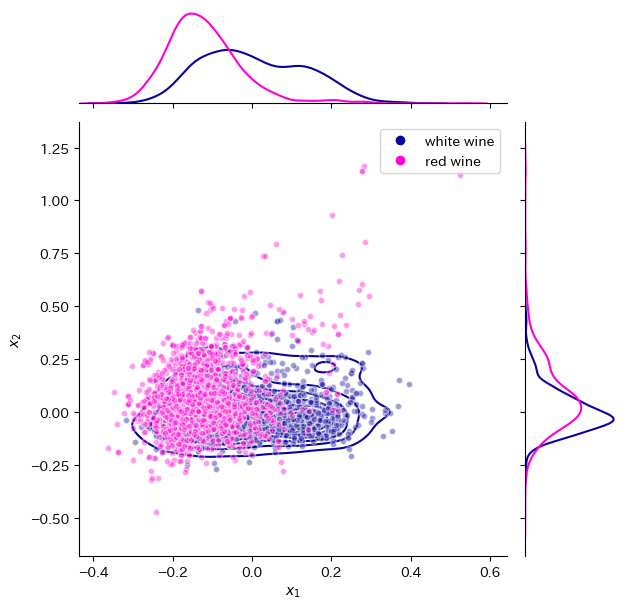

In [30]:
import seaborn as sns

def plot_data(data1, data2):
    """
    2次元データ（列0=x1, 列1=x2）を「分布の形（kde）＋点（scatter）」で重ねて可視化する関数。

    設計意図（なぜこう書くか）
    - data1 を「参照分布（基準）」として、滑らかな分布形状（等高線＋周辺分布）で見せる。
    - data2 を「比較対象（テスト）」として、点群（散布図）と周辺分布（kde）を同じ図に重ねる。
    - こうすると「data2 が data1 に対してどこにズレたか（中心・広がり・形）」を直感的に確認できる。
    - jointplot を土台にすると、中央（2次元）＋上（x方向）＋右（y方向）の3領域を一括で作れるので、
      “2次元のズレ” と “各軸方向のズレ” を同時に見られる。

    前提
    - data1, data2 は shape=(N, 2) の配列（NumPy配列など）を想定。
      data[:,0] が x1、data[:,1] が x2。
    """

    # --- 1) 土台の作成：data1 を "参照分布" として描く -------------------------
    # sns.jointplot は JointGrid を返す：
    #   - fig.ax_joint   : 中央の2次元プロット領域
    #   - fig.ax_marg_x  : 上側のx方向周辺分布領域
    #   - fig.ax_marg_y  : 右側のy方向周辺分布領域
    #
    # kind="kde" により、中央は data1 の 2次元カーネル密度推定（等高線）になる。
    # height=6  : 図のサイズ（大きさ）の基準
    # ratio=4   : 中央領域（joint）が周辺領域（marginal）よりどれだけ大きいか
    # color     : data1 の分布の色
    # zorder=0  : 描画順序（小さいほど背面）→ 参照分布を背面に置き、あとから data2 を前面に重ねる
    fig = sns.jointplot(
        x=data1[:, 0], y=data1[:, 1],
        kind="kde",
        height=6,
        ratio=4,
        color="#0A009B",
        zorder=0
    )
    
    sns.scatterplot(
        x=data1[:, 0], y=data1[:, 1],
        color="#0A009B",
        s=20,
        edgecolor="w",
        linewidth=1,
        alpha=0.4,
        ax=fig.ax_joint,
        zorder=0
    )

    # 軸ラベル（LaTeX記法）を設定：この後に重ねる data2 も同じ軸で比較できるようにする
    fig.set_axis_labels(r"$x_1$", r"$x_2$")

    # --- 2) data2 を "比較対象" として中央の領域に散布図で重ねる -------------
    # sns.scatterplot を ax=fig.ax_joint に指定することで、
    # jointplot が作った中央領域の上に data2 の点を追加描画できる。
    #
    # s=70         : 点の大きさ
    # edgecolor='k': 点の縁取りを黒にして視認性を上げる（背景や等高線と区別しやすい）
    # linewidth=2  : 縁取り線の太さ
    # zorder=1     : data1（zorder=0）の上に表示されるよう前面に
    sns.scatterplot(
        x=data2[:, 0], y=data2[:, 1],
        color="#FF00D4",
        alpha=0.4,
        s=20,
        edgecolor="w",
        linewidth=1,
        ax=fig.ax_joint,
        zorder=1
    )

    # --- 3) data2 の周辺分布（1次元kde）を上・右の領域に重ねる --------------
    # data1 は jointplot(kind="kde") の設定により、
    # 中央だけでなく周辺領域にも data1 の分布が描かれている（実行環境/バージョンにより見え方差あり）。
    # ここで data2 の 1次元kde を重ねることで、各軸方向のズレを見比べやすくする。
    #
    # 上側（x方向の周辺分布）
    sns.kdeplot(
        x=data2[:, 0],
        ax=fig.ax_marg_x,
        color="#FF00D4"
    )

    # 右側（y方向の周辺分布）
    sns.kdeplot(
        y=data2[:, 1],
        ax=fig.ax_marg_y,
        color="#FF00D4"
    )

    # 注意：この関数は表示（描画）を目的としており、値は返さない設計にしている。
    # もし外側で追加編集（タイトル追加など）をしたいなら、最後に `return fig` として返す設計に変える。
    

# 前提：
# - seaborn と matplotlib は import 済み（sns, plt が使える）
# - plot_data(data1, data2) は上で定義済み
# - enc_h0, enc_h1 は shape=(N,2) の2次元表現（PCA後など）

plot_data(enc_h0, enc_h1)

# legend を付けたい場合（関数が fig を返さない設計なので、簡易に代理ハンドルを作る）
import matplotlib.lines as mlines

h0_handle = mlines.Line2D([], [], color="#0A009B", marker="o", linestyle="None",
                          markersize=8, markeredgecolor="w", label="white wine")
h1_handle = mlines.Line2D([], [], color="#FF00D4", marker="o", linestyle="None",
                          markersize=8, markeredgecolor="w", label="red wine")

plt.legend(handles=[h0_handle, h1_handle], loc="upper right")
plt.show()


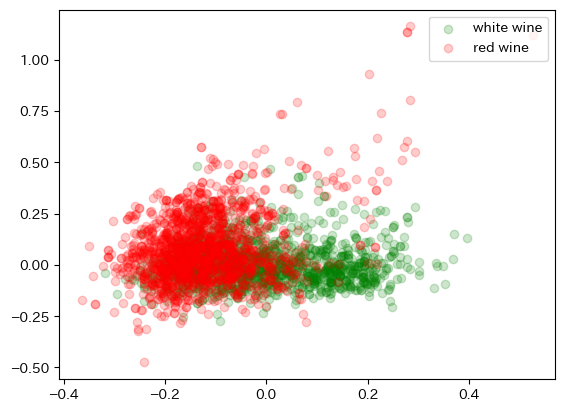

In [26]:
plt.scatter(enc_h0[:,0], enc_h0[:,1], alpha=0.2, color='green', label='white wine')
plt.scatter(enc_h1[:,0], enc_h1[:,1], alpha=0.2, color='red', label='red wine')
plt.legend(loc='upper right')
plt.show()

### オンラインMMDドリフト検知器の定義

目的：
- alibi-detect の `MMDDriftOnline` を使って、オンライン（逐次）にドリフトを検知する検知器 `cd` を作る。
- 「ドリフトが無い状態」での平均的な誤検知までの長さ（ERT）と、テスト窓サイズ（window_size）を設定する。
- 初期化時に、しきい値をブートストラップで推定して決める。

---

#### 1) パラメータ設定

- `ert = 50`  
  ドリフトが無い状況で、平均して 50 タイムステップ動くまで誤検知しないようにしたい（期待実行時間）。

- `window_size = 10`  
  テスト統計量（MMD）を更新・評価するために使う「直近データの窓」の長さ。

---

#### 2) しきい値の決め方（ブートストラップ）

- `n_bootstraps = 2500`  
  初期化時に参照データ `X_ref` からブートストラップ標本を作り、統計量の分布をシミュレーションして
  しきい値を計算する回数。

---

#### 3) 検知器の生成（重要な引数）

- `X_ref`  
  参照データ（ドリフトが無い基準データ）。ここを基準にテスト窓との距離（MMD）を追跡する。

- `backend='TensorFlow'`  
  計算の実装として PyTorch/TensorFlow を使う指定。

- `preprocess_fn=pca.transform`  
  入力データに前処理（ここでは PCA による 11次元→2次元変換）をかけてから MMD を計算する指定。

---

#### 4) なぜパラメータが小さめなのか（ノートの意図）

- `ert`, `window_size`, `n_bootstraps` は、一般的な実運用より小さめに設定されている。
- 理由は、検知器の平均的な挙動を「多数回の実行で」短時間にデモするため（計算時間を抑えるため）。


In [19]:
from alibi_detect.cd import MMDDriftOnline

ert = 50
window_size = 50
cd = MMDDriftOnline(
    X_ref,
    ert=ert,
    window_size=window_size,
    backend='TensorFlow',
    preprocess_fn=pca.transform,
    n_bootstraps=2500
)

Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 50/50 [02:31<00:00,  3.03s/it]


### time_run(cd, X, window_size) の目的と動き

目的：
- オンラインドリフト検知器 `cd` にデータを 1点ずつ流し、
  「ドリフト検知（is_drift=1）が出るまでに何ステップかかったか」を run-time として返す。

処理の流れ：
1) `n = X.shape[0]`  
   - 入力データ `X` のサンプル数（行数）を取得する。

2) `perm = np.random.permutation(n)`  
   - サンプルの順番をランダムに並び替えるための添字列を作る。

3) `t = 0`  
   - 検知までに経過したステップ数（run-time）のカウンタを 0 で初期化する。

4) `cd.reset_state()`  
   - 検知器は内部状態を持つので、試行ごとに状態をリセットする（前の試行の影響を消す）。

5) `while True:` で繰り返し  
   - `cd.predict(X[perm[t % n]])` により、1サンプルずつ検知器へ入力する。
   - 返り値 `pred['data']['is_drift']` が 1 ならドリフト検知 → `t` を返して終了。
   - まだ検知されなければ `t += 1` して次のサンプルへ進む。

補足：
- `t % n` を使うので、`t` が `n` を超えてもデータを先頭から繰り返し流す挙動になる。
- `window_size` は引数にあるが、この関数内では直接使っていない（検知器 `cd` 側の設定として効いている）。


In [20]:
def time_run(cd, X, window_size):
    n = X.shape[0]
    perm = np.random.permutation(n)
    t = 0
    cd.reset_state()
    while True:
        pred = cd.predict(X[perm[t%n]])
        if pred['data']['is_drift'] == 1:
            return t
        else:
            t += 1

### run-time 分布の確認

目的：
- 「ドリフト無し（白ワインの hold-out データ）」を流したときに、
  誤検知までの run-time がどんな分布になるかを調べる。
- 平均 run-time が設定した `ert`（期待実行時間）に近いかを確認する。
- ただし理論的に狙っている run-time 分布（平均 `ert` の幾何分布）は分散が大きいので、
  試行回数が少ないと実測平均が `ert` に必ずしも近づかない点に注意する。
- その代わり、Q-Q プロットが直線に近いかを見て「分布として狙いどおりか」を確認する。

コードがしていること:

1) 試行回数を決める
- `n_runs = 250`
  - run-time を 250 回測る。

1) run-time を 250 個集める（ドリフト無しデータで）
- `times_h0 = [time_run(cd, X_h0, window_size) for _ in range(n_runs)]`
  - `time_run` を繰り返し呼び、誤検知までのステップ数をリスト化する。
  - `X_h0` は「白ワインの hold-out（ドリフト無し想定）」。

1) 平均 run-time を出力
- `print(f"Average run-time under no-drift: {np.mean(times_h0)}")`
  - 実測の平均が `ert`（例：50）に近いかの確認。

1) Q-Q プロットで分布の一致度を確認
- `scipy.stats.probplot(np.array(times_h0), dist=scipy.stats.geom, sparams=1/ert, plot=plt)`
  - 実測 `times_h0` の分位点と、理論の幾何分布（平均が `ert` になるように設定）を比較する。
  - 点が直線状に並べば、分布としては理論（狙い）に近いと判断できる。

補足：
- `sparams=1/ert` は、幾何分布のパラメータを「平均が `ert` になるように」指定している意図。


Average run-time under no-drift: 32.392


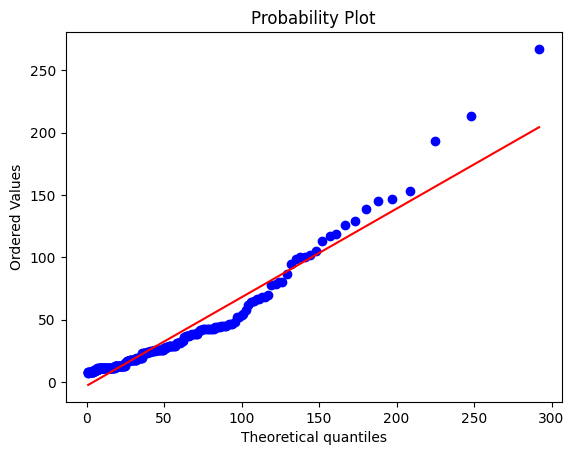

In [21]:
n_runs = 250
times_h0 = [time_run(cd, X_h0, window_size) for _ in range(n_runs)]
print(f"Average run-time under no-drift: {np.mean(times_h0)}")
_ = scipy.stats.probplot(np.array(times_h0), dist=scipy.stats.geom, sparams=1/ert, plot=plt)

### ドリフト有りデータで run-time を測る

目的：
- 直前の「ドリフト無し（白ワイン hold-out）」と同じ手順で、
  今度は「ドリフト有り（赤ワイン）」を流したときの run-time を測る。
- ドリフトが本当にあるなら、誤検知を待つより早く検知されるはずなので、
  平均 run-time は大幅に小さくなることを確認する。

コードがしていること：
1) `n_runs = 250`
   - 250回試行する。

2) `times_h1 = [time_run(cd, X_corr, window_size) for _ in range(n_runs)]`
   - `X_corr`（赤ワイン＝ドリフト側）を使って run-time を250個集める。

3) `print(f"Average run-time under drift: {np.mean(times_h1)}")`
   - ドリフト有り時の平均 run-time を出す。

出力例の解釈：
- `Average run-time under drift: 6.004`
  - 平均で約6ステップでドリフト検知されている。
  - これは、ドリフト無し時（平均が ert ≈ 50 を狙う）よりかなり短く、
    「赤ワインは白ワイン基準から分布がズレている → 早く検知できる」
    という挙動を示している。


In [22]:
n_runs = 250
times_h1 = [time_run(cd, X_corr, window_size) for _ in range(n_runs)]
print(f"Average run-time under drift: {np.mean(times_h1)}")

Average run-time under drift: 14.996


### 疑似時系列データとして可視化

#### 前提
- ワイン品質データは本来「時系列」ではなく、各行が独立サンプル。
- ここでは **白ワイン→赤ワイン** の順に連結して、人工的に「変化点（ドリフト点）」を作る。
- `X_h0`：白ワイン（ドリフトなし想定の hold-out）
- `X_corr`：赤ワイン（ドリフト側）
- `pca`：白ワインの一部 `X_train` で `fit` 済みの PCA（11次元→2次元）

---

#### 1) 擬似時系列（ストリーム）を作る
- `X_stream = vstack([X_h0, X_corr])` で、白→赤を1本につなげる。
- `cp = X_h0.shape[0]` が境目（白→赤の切替点）で、ここが擬似変化点。

---

#### 2) PCAで2次元に変換する
- `Z_stream = pca.transform(X_stream)` で、ストリーム全体を2次元に落とす。
- `Z_ref = pca.transform(X_ref)` で、参照データも同じ空間に落として「基準平均」を作れるようにする。

狙い：
- 11次元のままだと目視しにくいので、2次元にして波形や変化を見やすくする。

---

#### 3) 波形としての可視化（PCA第1成分）
- `Z_stream[:, 0]`（第1主成分）を時系列の値として折れ線表示。
- `axvline(cp)` で境目を表示。
見え方：
- 白区間と赤区間で「値の中心（平均）」や「揺れ（ばらつき）」が変わると、境目以降で波形の位置が変わって見える。

---

#### 4) 「分布の変化点」を見やすくする簡易スコア
- 直近 `W` 点の平均（2次元ベクトル） `mu_win` を計算。
- 参照平均 `mu_ref` との差を距離 `||mu_win - mu_ref||` でスコア化。
- これを時系列で描くと「最近のデータの中心が参照からどれだけズレたか」が1本の線で見える。

ポイント：
- `W` を大きくすると滑らかだが反応が遅れる。
- `W` を小さくすると敏感だがノイズで上下しやすい。

---

#### まとめ
- 上の図（PCA第1成分の波形）は、白→赤で“波形の位置/揺れ”が変わる様子を見せる。
- 下の図（距離スコア）は、分布の中心のズレが境目以降で増える様子をより明確に見せる。


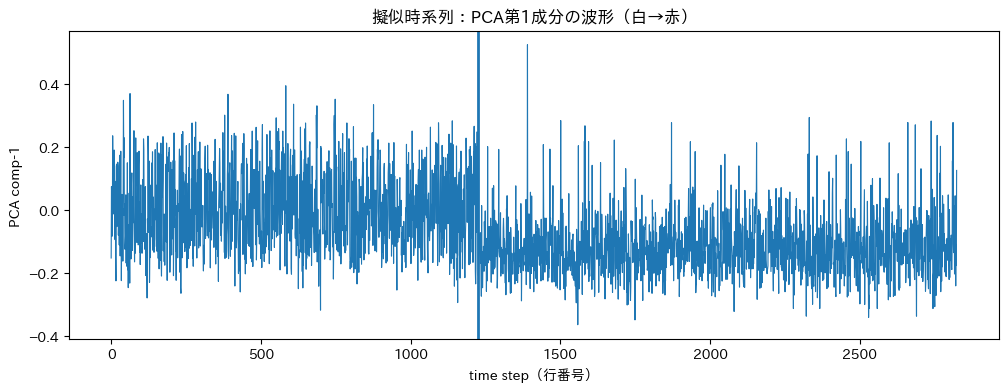

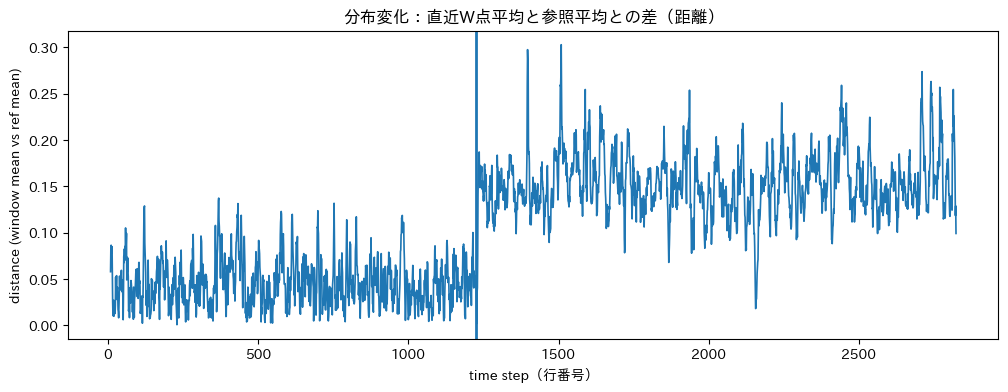

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# =========================
# 1) 擬似時系列を作る（白→赤の順に結合）
# =========================
X_stream = np.vstack([X_h0, X_corr])
cp = X_h0.shape[0]  # ここが「白→赤」の境目（擬似変化点）

# =========================
# 2) PCAで2次元へ（pca は X_train で fit 済みの前提）
# =========================
Z_stream = pca.transform(X_stream)     # shape: (T, 2)
Z_ref    = pca.transform(X_ref)        # 参照側も同じ変換

t = np.arange(Z_stream.shape[0])

# =========================
# 3) 波形として可視化（PCA 第1成分）
# =========================
plt.figure(figsize=(12, 4))
plt.plot(t, Z_stream[:, 0], linewidth=0.8)
plt.axvline(cp, linewidth=2)  # 変化点（境目）
plt.title("擬似時系列：PCA第1成分の波形（白→赤）")
plt.xlabel("time step（行番号）")
plt.ylabel("PCA comp-1")
plt.show()

# =========================
# 4) 分布変化を見やすくする簡易スコア：
#    直近W点平均 と 参照平均 の距離（2次元）
# =========================
W = 10  # window_size と揃えると直感が合う
mu_ref = Z_ref.mean(axis=0)

scores = np.full(Z_stream.shape[0], np.nan, dtype=float)
for i in range(W - 1, Z_stream.shape[0]):
    mu_win = Z_stream[i - W + 1 : i + 1].mean(axis=0)
    scores[i] = np.linalg.norm(mu_win - mu_ref)

plt.figure(figsize=(12, 4))
plt.plot(t, scores, linewidth=1.2)
plt.axvline(cp, linewidth=2)
plt.title("分布変化：直近W点平均と参照平均との差（距離）")
plt.xlabel("time step（行番号）")
plt.ylabel("distance (window mean vs ref mean)")
plt.show()
